In [ ]:
   import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/bftxg089s8bx86f/Financial%20Sentiment%20Data.csv?dl=1')

In [ ]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment'])

In [ ]:
y_train.value_counts()

neutral     2504
positive    1481
negative     688
Name: Sentiment, dtype: int64

In [ ]:
# balance data -> upsample minority class
n_neu = y_train.value_counts()['neutral']
n_pos = y_train.value_counts()['positive']
n_neg = y_train.value_counts()['negative']

train = pd.concat([X_train, y_train], axis=1)
train_pos = pd.concat([train[train.Sentiment=='positive'], 
                      train[train.Sentiment=='positive'].sample(n=(n_neu-n_pos), replace=True, random_state=42)])
train_neg = pd.concat([train[train.Sentiment=='negative'],
                       train[train.Sentiment=='negative'].sample(n=(n_neu-n_neg), replace=True, random_state=42)])
train_balanced = pd.concat([train_pos, train_neg,train[train.Sentiment=='neutral']])
X_train, y_train = train_balanced['Sentence'], train_balanced['Sentiment']

In [ ]:
y_train.value_counts()

positive    2504
negative    2504
neutral     2504
Name: Sentiment, dtype: int64

In [ ]:
max_tokens = 6000
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
    ngrams=2
)
text_vectorization.adapt(X_train)

In [ ]:
print(type(X_train))

<class 'pandas.core.series.Series'>


In [ ]:
y_test.value_counts()/y_test.shape[0]

neutral     0.535500
positive    0.317365
negative    0.147134
Name: Sentiment, dtype: float64

In [ ]:
train_vec = text_vectorization(X_train)
test_vec = text_vectorization(X_test)

In [ ]:
text_vectorization_sentiment = keras.layers.TextVectorization()
text_vectorization_sentiment.adapt(y_train)

n_sentiments = text_vectorization_sentiment.vocabulary_size()

sentiment_data_train_sparse = text_vectorization_sentiment(y_train)
sentiment_data_test_sparse = text_vectorization_sentiment(y_test)

In [ ]:
# sentiment_data_train_sparse = tf.convert_to_tensor(y_train.map({'neutral':[0],'positive':[1],'negative':[2]}).tolist())
# sentiment_data_test_sparse = tf.convert_to_tensor(y_test.map({'neutral':[0],'positive':[1],'negative':[2]}).tolist())

In [ ]:
units = 64

inputs = keras.Input(shape=(max_tokens, ))
x = keras.layers.Dense(units=128)(inputs)
x = keras.layers.Dropout(0.75)(x)
x = keras.layers.Dense(units=32)(x)
x = keras.layers.Dropout(0.75)(x)
x = keras.layers.Dense(units=8)(x)
x = keras.layers.Dropout(0.75)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6000)]            0         
                                                                 
 dense (Dense)               (None, 128)               768128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0     

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
history = model.fit(x = train_vec, 
          y = sentiment_data_train_sparse, 
          epochs=15,
          validation_data = (test_vec, sentiment_data_test_sparse))

Epoch 1/15
235/235 [==============================] - 10s 29ms/step - loss: 1.8072 - sparse_categorical_accuracy: 0.2893 - val_loss: 1.3393 - val_sparse_categorical_accuracy: 0.5115
Epoch 2/15
235/235 [==============================] - 5s 20ms/step - loss: 1.4743 - sparse_categorical_accuracy: 0.3975 - val_loss: 1.1893 - val_sparse_categorical_accuracy: 0.6270
Epoch 3/15
235/235 [==============================] - 5s 22ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.0622 - val_sparse_categorical_accuracy: 0.6270
Epoch 4/15
235/235 [==============================] - 4s 18ms/step - loss: 1.0877 - sparse_categorical_accuracy: 0.5296 - val_loss: 0.9791 - val_sparse_categorical_accuracy: 0.6749
Epoch 5/15
235/235 [==============================] - 3s 14ms/step - loss: 0.9882 - sparse_categorical_accuracy: 0.5710 - val_loss: 0.9040 - val_sparse_categorical_accuracy: 0.6809
Epoch 6/15
235/235 [==============================] - 5s 20ms/step - loss: 0.9166 - sparse_cat

In [ ]:
model.evaluate(x=test_vec, y=sentiment_data_test_sparse)

37/37 [==============================] - 0s 6ms/step - loss: 0.9237 - sparse_categorical_accuracy: 0.6784


[0.923673689365387, 0.6783575415611267]

37/37 [==============================] - 0s 6ms/step


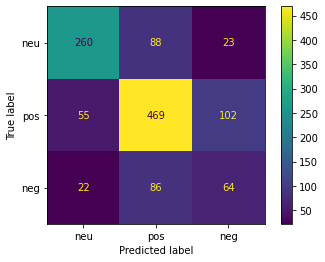

In [ ]:
pred = np.argmax(model.predict(x=test_vec),axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix(tf.squeeze(sentiment_data_test_sparse), pred, labels=[2,3,4]),
                       display_labels=['neu','pos','neg'])
disp.plot()
plt.show()

In [ ]:
f1_score(tf.squeeze(sentiment_data_test_sparse), pred, average='weighted')

0.6810856504444006

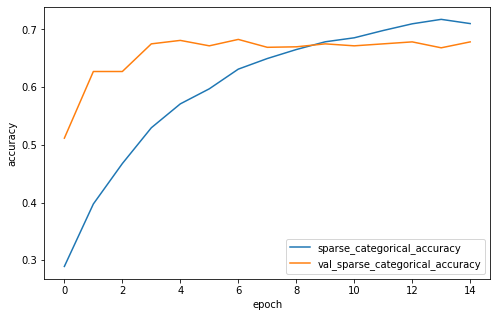

In [ ]:
pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()